# Steps to conduct

1. Setup (Databricks/AWS/GitHub)     ---------------------------                       <-- We are currently here!
2. EDA (within Databricks per PySpark/SQL)
3. Feature Selection (Databricks)
4. Write to S3
5. ML case on AWS Sagemaker (model, scores, etc.)
6. Deployment on AWS Sagemaker
6. Create presentation
7. (20:80 or optional task)

# Import Data

In [0]:
# connect so s3 bucket
# get credentials
import os

ACCESS_KEY = os.getenv("AWS_ACCESS_KEY")
SECRET_KEY = os.getenv("AWS_SECRET_KEY")
ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
AWS_BUCKET_NAME = "aida-project"
MOUNT_NAME = "data"

# mount data
dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, AWS_BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
display(dbutils.fs.ls("/mnt/%s" % MOUNT_NAME))

--------------------------------------------------------------------------- 
 ExecutionError Traceback (most recent call last)
 <command-3321533958678355> in <module> 
 10 
 11 # mount data 
 ---> 12 dbutils . fs . mount ( "s3a://%s:%s@%s" % ( ACCESS_KEY , ENCODED_SECRET_KEY , AWS_BUCKET_NAME ) , "/mnt/%s" % MOUNT_NAME ) 
 13 display ( dbutils . fs . ls ( "/mnt/%s" % MOUNT_NAME ) ) 

 /local_disk0/tmp/1605516424926-0/dbutils.py in f_with_exception_handling (*args, **kwargs) 
 312 exc . __context__ = None 
 313 exc . __cause__ = None 
 --> 314 raise exc
 315 return f_with_exception_handling
 316 

 ExecutionError : An error occurred while calling o242.mount.
: java.rmi.RemoteException: java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/data; nested exception is: 
	java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/data
	at com.databricks.backend.daemon.data.client.DbfsClient.send0(DbfsClient.scala:123)
	at com.databricks.backend.daemon.data.client.DbfsClient.sendIdempotent(DbfsClient.scala:63)
	at com.databricks.backend.daemon.dbutils.DBUtilsCore.mount(DBUtilsCore.scala:471)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:380)
	at py4j.Gateway.invoke(Gateway.java:295)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:251)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/data
	at scala.Predef$.require(Predef.scala:281)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.$anonfun$insertMount$1(MetadataManager.scala:220)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.withRetries(MetadataManager.scala:322)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.insertMount(MetadataManager.scala:216)
	at com.databricks.backend.daemon.data.server.handler.MountHandler.receive(MountHandler.scala:77)
	at com.databricks.backend.daemon.data.server.handler.CEMountHandler.receive(MountHandler.scala:122)
	at com.databricks.backend.daemon.data.server.session.SessionContext.$anonfun$queryHandlers$1(SessionContext.scala:97)
	at com.databricks.backend.daemon.data.server.session.SessionContext.$anonfun$queryHandlers$1$adapted(SessionContext.scala:96)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at com.databricks.backend.daemon.data.server.session.SessionContext.queryHandlers(SessionContext.scala:96)
	at com.databricks.backend.daemon.data.server.DbfsServerBackend$$anonfun$receive$3.applyOrElse(DbfsServerBackend.scala:354)
	at com.databricks.backend.daemon.data.server.DbfsServerBackend$$anonfun$receive$3.applyOrElse(DbfsServerBackend.scala:322)
	at com.databricks.rpc.ServerBackend.$anonfun$internalReceive$2(ServerBackend.scala:53)
	at com.databricks.rpc.ServerBackend$$anonfun$commonReceive$1.applyOrElse(ServerBackend.scala:80)
	at com.databricks.rpc.ServerBackend$$anonfun$commonReceive$1.applyOrElse(ServerBackend.scala:80)
	at com.databricks.rpc.ServerBackend.$anonfun$internalReceive$1(ServerBackend.scala:49)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$4(UsageLogging.scala:432)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:240)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:235)
	

In [0]:
def show_quantiles(dataframe, list_columns, percentiles):
  df_quantile = spark.createDataFrame(
      zip(percentiles, *df.approxQuantile(columns, percentiles, 0.1)), 
      ["Pecentile"] + columns
  )
  df_quantile.show()
  
  return df_quantile

In [0]:
display(dbutils.fs.ls("/mnt/%s/TSV" % MOUNT_NAME))

path name size dbfs:/mnt/data/TSV/name.basics.tsv name.basics.tsv 579976550 dbfs:/mnt/data/TSV/title.akas.tsv title.akas.tsv 969441812 dbfs:/mnt/data/TSV/title.basics.tsv title.basics.tsv 537519832 dbfs:/mnt/data/TSV/title.principals.tsv title.principals.tsv 1622240736 dbfs:/mnt/data/TSV/title.ratings.tsv title.ratings.tsv 16907124

In [0]:
df_names = spark.read.load("dbfs:/mnt/data/TSV/name.basics.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_akas = spark.read.load("dbfs:/mnt/data/TSV/title.akas.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_basics = spark.read.load("dbfs:/mnt/data/TSV/title.basics.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_principals = spark.read.load("dbfs:/mnt/data/TSV/title.principals.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_ratings = spark.read.load("dbfs:/mnt/data/TSV/title.ratings.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")

In [0]:
list_dfs = [df_names, df_akas, df_basics, df_principals, df_ratings]

for df in list_dfs:
  df.printSchema()

root
-- nconst: string (nullable = true)
-- primaryName: string (nullable = true)
-- birthYear: string (nullable = true)
-- deathYear: string (nullable = true)
-- primaryProfession: string (nullable = true)
-- knownForTitles: string (nullable = true)

root
-- titleId: string (nullable = true)
-- ordering: integer (nullable = true)
-- title: string (nullable = true)
-- region: string (nullable = true)
-- language: string (nullable = true)
-- types: string (nullable = true)
-- attributes: string (nullable = true)
-- isOriginalTitle: string (nullable = true)

root
-- tconst: string (nullable = true)
-- titleType: string (nullable = true)
-- primaryTitle: string (nullable = true)
-- originalTitle: string (nullable = true)
-- isAdult: integer (nullable = true)
-- startYear: string (nullable = true)
-- endYear: string (nullable = true)
-- runtimeMinutes: string (nullable = true)
-- genres: string (nullable = true)

root
-- tconst: string (nullable = true)
-- ordering: integer (nullable = true)
-- nconst: string (nullable = true)
-- category: string (nullable = true)
-- job: string (nullable = true)
-- characters: string (nullable = true)

root
-- tconst: string (nullable = true)
-- averageRating: double (nullable = true)
-- numVotes: integer (nullable = true)

### describing df_akas dataset

In [0]:
df_akas.printSchema()

root
-- titleId: string (nullable = true)
-- ordering: integer (nullable = true)
-- title: string (nullable = true)
-- region: string (nullable = true)
-- language: string (nullable = true)
-- types: string (nullable = true)
-- attributes: string (nullable = true)
-- isOriginalTitle: string (nullable = true)

In [0]:
df_akas.describe().show()

+-------+---------+------------------+-----------+--------+--------+--------+------------------+--------------------+
summary| titleId| ordering| title| region|language| types| attributes| isOriginalTitle|
+-------+---------+------------------+-----------+--------+--------+--------+------------------+--------------------+
 count| 19549634| 19549634| 19549634|19549630|19549630|19549630| 19549630| 19549630|
 mean| null|3.9788073781841646| NaN| null| null| null| null|0.021393644313851618|
 stddev| null| 3.042257275711086| NaN| null| null| null| null| 0.14469263066188814|
 min|tt0000001| 1| !Huff| AD| \N| \N|16mm release title| 0|
 max|tt9916852| 138|영화 테스트| \N| zu| working| weekend title| \N|
+-------+---------+------------------+-----------+--------+--------+--------+------------------+--------------------+

In [0]:
'''
Conclusions
- There are 19.5 m. Titles
- ordering (number to uniquely identify rows for a given titleId)
  - min appearance of title in the akas dataset = 1
  - max appearance of title in the akas dataset = 138
  - max appearance of title in the akas dataset = 3.97
- check portion of '\N' in region, language, types, attributes
'''

### working on sample dataset

In [0]:
#creating sample and look into it 
#df_akas_sample = df_akas.sample(False, 0.00002, 42)
df_akas_sample = df_akas
df_akas_sample.show()

+---------+--------+--------------------+------+--------+-----------+--------------------+---------------+
 titleId|ordering| title|region|language| types| attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+--------------------+---------------+
tt0000001| 1|Carmencita - span...| HU| \N|imdbDisplay| \N| 0|
tt0000001| 2| Καρμενσίτα| GR| \N| \N| \N| 0|
tt0000001| 3| Карменсита| RU| \N| \N| \N| 0|
tt0000001| 4| Carmencita| US| \N| \N| \N| 0|
tt0000001| 5| Carmencita| \N| \N| original| \N| 1|
tt0000002| 1|Le clown et ses c...| \N| \N| original| \N| 1|
tt0000002| 2| A bohóc és kutyái| HU| \N|imdbDisplay| \N| 0|
tt0000002| 3|Le clown et ses c...| FR| \N| \N| \N| 0|
tt0000002| 4|Clovnul si cainii...| RO| \N|imdbDisplay| \N| 0|
tt0000002| 5| Клоун и его собаки| RU| \N| \N| \N| 0|
tt0000002| 6|The Clown and His...| US| \N| \N|literal English t...| 0|
tt0000003| 1| Sarmanul Pierrot| RO| \N|imdbDisplay| \N| 0|
tt0000003| 2| Szegény Pierrot| HU| \N|imdbDisplay| \N| 0|
tt0000003| 3| Бедный Пьеро| RU| \N| \N| \N| 0|
tt0000003| 4| Pauvre Pierrot| \N| \N| original| \N| 1|
tt0000003| 5| Poor Pierrot| GB| \N|imdbDisplay| \N| 0|
tt0000003| 6| Pauvre Pierrot| FR| \N| \N| \N| 0|
tt0000004| 1| Un bon bock| \N| \N| original| \N| 1|
tt0000004| 2| Un ţap de bere| RO| \N| \N| \N| 0|
tt0000004| 3| Un bon bock| FR| \N| \N| \N| 0|
+---------+--------+--------------------+------+--------+-----------+--------------------+---------------+
only showing top 20 rows

In [0]:
df_akas_sample.describe().show()

+-------+---------+------------------+-----------+--------+--------+--------+------------------+--------------------+
summary| titleId| ordering| title| region|language| types| attributes| isOriginalTitle|
+-------+---------+------------------+-----------+--------+--------+--------+------------------+--------------------+
 count| 19549634| 19549634| 19549634|19549630|19549630|19549630| 19549630| 19549630|
 mean| null|3.9788073781841646| NaN| null| null| null| null|0.021393644313851618|
 stddev| null| 3.042257275711086| NaN| null| null| null| null| 0.14469263066188814|
 min|tt0000001| 1| !Huff| AD| \N| \N|16mm release title| 0|
 max|tt9916852| 138|영화 테스트| \N| zu| working| weekend title| \N|
+-------+---------+------------------+-----------+--------+--------+--------+------------------+--------------------+

show nan values portion

In [0]:
no_values_cols = ['titleId', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle']

for item in no_values_cols:
  column = item
  print(item)
  print(df_akas_sample.select(column).where(fr'{column} = "\\N"').count() / df_akas_sample.select(column).count())


titleId
0.0
ordering
0.0
title
0.0
region
0.024438513784963953
language
0.16900142478370694
types
0.9415350691475861
attributes
0.9904533251108435
isOriginalTitle
0.0001119714057050889

In [0]:
no_values_cols = ['titleId', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle']

for item in no_values_cols:
  column = item
  print(item)
  print(df_akas_sample.select(column).where(fr'{column} = "null"').count() / df_akas_sample.select(column).count())

titleId
0.0
ordering
0.0
title
0.0
region
0.0
language
0.0
types
0.0
attributes
0.0
isOriginalTitle
0.0

In [0]:
df_akas_sample('attributes').isNull().count() 

--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-3955913033488570> in <module> 
 ----> 1 df_akas_sample ( 'attributes' ) . isNull ( ) . count ( ) 

 TypeError : 'DataFrame' object is not callable

In [0]:
'''
Conclusio
- types has 94.6% and attributes 98.4% empty values = drop? or leading to good prediction?
- region with 2.9% and language 14.3% = how to go forward here to defne
'''

Out[64]: '\nConclusio\n- types has 94.6% and attributes 98.4% empty values = drop? or leading to good prediction?\n- region with 2.9% and language 14.3% = how to go forward here to defne\n'

### working step by step through columns

show titles by max ordering

In [0]:
df_akas_sample_groupby = df_akas_sample.groupBy('titleId').agg({'ordering':'max'}).sort('max(ordering)', ascending=False).limit(500)
display(df_akas_sample_groupby)

titleId max(ordering) tt0168366 138 tt8185052 98 tt8052676 88 tt0076759 85 tt0103369 85 tt8187756 77 tt8232202 76 tt0060196 76 tt0080684 71 tt0057012 68 tt0086190 68 tt0029583 67 tt0088247 66 tt0071562 65 tt2488496 63 tt0082971 63 tt0068646 62 tt0058461 62 tt0111161 61 tt0120762 61 tt0087332 61 tt0245429 61 tt5323662 61 tt0033467 61 tt0064116 60 tt0367882 60 tt0055928 60 tt1201607 60 tt0121765 59 tt0096874 59 tt0078748 59 tt0080339 59 tt0028950 59 tt0052357 58 tt0047396 58 tt0075860 58 tt0078788 58 tt0103064 58 tt0090605 58 tt0110357 58 tt0120915 58 tt0047478 58 tt0044706 58 tt0042332 57 tt0120737 57 tt0121766 57 tt0095016 57 tt1844624 57 tt0050083 56 tt0064208 56 tt2310332 56 tt1790809 56 tt2948356 56 tt0015648 56 tt2418644 56 tt0067140 56 tt6751668 56 tt0099685 56 tt0317705 55 tt0038650 55 tt0059578 55 tt0073195 55 tt0848228 55 tt0089880 55 tt0077687 55 tt0247082 55 tt0053125 55 tt0266543 55 tt0083658 55 tt0047296 55 tt0064757 55 tt0066078 55 tt0053291 54 tt0078966 54 tt0068638 54 tt0058751 54 tt0042876 54 tt0070047 54 tt0468569 54 tt0032138 54 tt0065555 54 tt2278871 54 tt0120587 54 tt0102926 54 tt0104431 54 tt1345836 54 tt2527336 54 tt0056111 54 tt0424205 54 tt0398286 54 tt0077402 54 tt0190332 54 tt0239195 54 tt0083944 54 tt0099674 53 tt0099088 53 tt0031381 53 tt0073486 53 tt0044916 53 tt0077869 53 tt4630562 53 tt0058150 53 tt0027977 53 tt0062622 53 tt0080749 53 tt0080319 53 tt0046912 53 tt0072271 53 tt1217209 53 tt2820852 52 tt1568921 52 tt0055254 52 tt0312004 52 tt0099423 52 tt0067355 52 tt0054047 52 tt0067303 52 tt2096673 52 tt0055630 52 tt4777008 52 tt0032553 52 tt0095327 52 tt0107290 52 tt0087469 52 tt0056452 52 tt0046876 52 tt0081505 52 tt0059742 52 tt0057076 52 tt0417741 52 tt0369610 52 tt0040522 52 tt2452042 52 tt2294629 51 tt0083907 51 tt0053285 51 tt0796366 51 tt0070078 51 tt0329774 51 tt0063032 51 tt0892791 51 tt0105236 51 tt0083866 51 tt0056592 51 tt0066995 51 tt0091251 51 tt0062512 51 tt0070735 51 tt1751105 51 tt0070328 51 tt0061576 51 tt1905041 51 tt0172156 50 tt0063501 50 tt1453405 50 tt0075686 50 tt0088763 50 tt0167261 50 tt0114369 50 tt0076752 50 tt0119567 50 tt1596343 50 tt0050986 50 tt0044079 50 tt0108052 50 tt0096283 50 tt0120338 50 tt0079802 50 tt0046672 50 tt0059800 50 tt0071784 50 tt0040746 49 tt0337978 49 tt1285016 49 tt0241527 49 tt0055031 49 tt0112864 49 tt1399103 49 tt8185002 49 tt0765429 49 tt0064175 49 tt1386697 49 tt1298650 49 tt1318514 49 tt0120347 49 tt0050613 49 tt1302559 49 tt0143145 49 tt0033870 49 tt0094226 49 tt0903624 49 tt0071721 49 tt0412142 49 tt0111987 49 tt1346284 49 tt0172495 49 tt0050976 49 tt0167260 49 tt0080761 49 tt0082694 48 tt0077651 48 tt0093409 48 tt1055369 48 tt1259571 48 tt0499549 48 tt0082340 48 tt1375666 48 tt2386490 48 tt0080057 48 tt0050585 48 tt1170358 48 tt0071807 48 tt0110912 48 tt0082096 48 tt0068767 48 tt0084787 48 tt0092546 48 tt0058182 48 tt0192897 48 tt0021749 48 tt0063442 48 tt1132620 48 tt1104001 48 tt0103644 48 tt0106179 48 tt0980970 48 tt1637688 48 tt0462499 48 tt0078437 48 tt0117731 48 tt0079200 48 tt0097576 48 tt0061578 48 tt0106308 48 tt2567026 48 tt1648190 47 tt0372784 47 tt0112401 47 tt0457430 47 tt0098084 47 tt0053198 47 tt0060848 47 tt0074156 47 tt0985699 47 tt0120586 47 tt0311113 47 tt0266697 47 tt0338013 47 tt0076740 47 tt0479952 47 tt6105098 47 tt0246460 47 tt8936990 47 tt1392170 47 tt1264074 47 tt0167404 47 tt0092007 47 tt0087843 47 tt7131622 47 tt0056801 47 tt0090264 47 tt0114746 47 tt0097428 47 tt0066921 47 tt0096969 47 tt0042192 47 tt0046268 47 tt0087544 47 tt0245574 47 tt0036775 47 tt0077416 47 tt0049406 47 tt0079945 47 tt0070034 47 tt3691740 47 tt0013442 47 tt0114709 47 tt2277860 47 tt1843866 47 tt0037522 46 tt0071230 46 tt0926084 46 tt0096438 46 tt0072890 46 tt0844471 46 tt0048960 46 tt0099487 46 tt0361748 46 tt1457767 46 tt0043014 46 tt0120815 46 tt1025100 46 tt8446056 46 tt1323594 46 tt0081398 46 tt0472181 46 tt1013752 46 tt4425200 46 tt0060897 46 tt0031322 46 tt1396484 46 tt0062807 46 tt0133093 46 tt0093779 46 tt0944947 46 tt0295297 46

In [0]:
df_akas_sample.filter((df_akas_sample['titleId'] == "tt0168366")).show()

+---------+--------+--------------------+------+--------+-----------+--------------------+---------------+
 titleId|ordering| title|region|language| types| attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+--------------------+---------------+
tt0168366| 100|Pokémon: Serie So...| ES| \N| \N|twentieth season ...| 0|
tt0168366| 101|Pokémon the Serie...| XWW| en| \N| fourth season title| 0|
tt0168366| 102| Pokémon| CA| en|imdbDisplay| \N| 0|
tt0168366| 103|Pokémon: Campeões...| BR| \N| \N| fourth season title| 0|
tt0168366| 104|Pokemon 1 - Minä ...| IT| \N| \N| video box title| 0|
tt0168366| 105| Pokémon| IT| \N|imdbDisplay| \N| 0|
tt0168366| 106| Pokémon: Advanced| ES| \N| \N| sixth season title| 0|
tt0168366| 107|Pokémon: Aventura...| ES| \N| \N| second season title| 0|
tt0168366| 108|Pokémon the Serie...| XWW| en| \N| third season title| 0|
tt0168366| 109|Pokémon - Die TV-...| DE| \N| \N|twentieth season ...| 0|
tt0168366| 10|Pokémon: Johto Le...| US| \N| \N| fourth season title| 0|
tt0168366| 110|Pokémon: ¡Hazte c...| ES| \N| \N| first season title| 0|
tt0168366| 111|Pokémon: Haladó n...| HU| \N| \N| sixth season title| 0|
tt0168366| 112|Pocket Monsters D...| JP| en| \N| fifth season title| 0|
tt0168366| 113|Pokémon: Indigo L...| US| \N| \N| first season title| 0|
tt0168366| 114|Pokémon: Master Q...| US| \N| \N| fifth season title| 0|
tt0168366| 115| Pokémon| XWW| en|imdbDisplay| \N| 0|
tt0168366| 116|Pokémon-serie: Di...| NL| \N| \N| fourth season title| 0|
tt0168366| 117|Сериал "Покемон": XY| RU| \N| \N| \N| 0|
tt0168366| 118|Pokémon the Serie...| XWW| en| \N|seventh season title| 0|
+---------+--------+--------------------+------+--------+-----------+--------------------+---------------+
only showing top 20 rows

COL REGION

In [0]:
df_akas_sample_groupby_region = df_akas_sample.groupBy('region').count().sort('count', ascending=False).limit(200)
display(df_akas_sample_groupby_region)

region count FR 2429418 DE 2391842 ES 2379351 JP 2375843 IT 2366689 IN 2328300 PT 2327511 US 891649 \N 477764 GB 192976 XWW 119222 CA 100024 BR 78271 GR 73919 FI 66306 HU 60904 AU 57007 RU 56559 PL 51478 SE 48534 MX 46401 XWG 46036 DK 45959 AR 43542 TR 31706 NL 28602 SUHH 26989 BG 22960 BE 22436 AT 21617 RO 21071 NO 19723 HK 19195 RS 16794 PH 15216 XYU 12945 CZ 12333 KR 11351 IL 10082 UA 9853 CN 9639 HR 9402 DDDE 8614 IE 8079 VE 8029 LT 7624 CH 7533 IR 7406 SI 7390 CSHH 7188 CL 7076 PE 6216 UY 6036 TW 5882 NZ 5557 EE 5272 XEU 4639 ZA 4532 CO 4383 SK 4145 NG 4089 EG 4040 VN 3009 ID 2958 SG 2609 TH 2181 PK 2164 MY 2010 CU 1923 AL 1674 DO 1619 BD 1614 IS 1529 BA 1527 LV 1352 GE 1101 PR 1045 LB 980 AE 938 LK 703 MA 640 EC 590 AZ 585 YUCS 578 TN 569 MK 560 NP 553 DZ 551 LU 498 CY 480 PA 472 AM 462 BO 439 CR 438 KZ 404 KP 328 BY 325 XAS 315 KE 308 SY 280 IQ 252 GH 239 CSXX 230 PY 227 SA 225 JO 223 QA 209 TT 207 MT 203 SN 201 JM 197 KH 184 BF 181 AF 178 XKV 176 GT 175 PS 173 CM 169 SM 158 UG 151 MN 144 KW 137 HT 122 UZ 116 MD 108 KG 107 XKO 107 XSA 98 VI 98 BS 92 MZ 89 ET 89 GP 88 BH 86 MM 83 SV 82 TZ 82 MC 82 NI 82 AO 77 HN 77 ZW 72 NA 71 MO 68 CG 66 ME 65 LA 61 ML 59 RW 58 GI 58 MU 57 CI 56 BJ 55 GU 50 SD 49 NE 47 BT 46 BB 36 LI 36 GL 36 TJ 35 BUMM 34 CD 34 TG 33 FO 33 GA 33 FJ 31 VDVN 31 ZM 29 MV 29 AD 28 MG 27 BM 27 AW 27 AN 25 LY 24 GN 24 TM 24 BI 23 SL 23 XPI 22 BZ 22 TD 20 MQ 19 IM 19 YE 19 RE 19 KY 18 PF 18 SZ 17 PG 17 AG 16 SR 16 MW 16 TL 15 OM 15 GW 13 SO 12 MR 12 LR 12

In [0]:
print(df_akas_sample.select("region").distinct().count())
display(df_akas_sample.select("region").distinct())

region DZ LT YUCS CI FI AZ SC UA RO ZM SL NL LA DDDE BS MN VDVN PL AM PS MK MX XSA XKO GL EE SM CN AT RU IQ NA \N CG AD HR LI SV CZ null NP PT SO BUMM PG GH HK CV TW BD PY LB CL TO ID LY AU PK SA CA BM NE UZ GB MT BR KZ BY HN XSI MD GT DE GN AW ES IR EC MO BH IL TR VE MR ZA CR XEU GU KR TZ US RS XWW AL CSHH MY IN JM MQ AE CM TG RW FR XKV CH MG TN ZRCD NU GR PA TD GI SD AG MC DJ XPI BA JO ET SG KP BF IT CU GW FO SE BG PH GE SK PE LV MU LS MZ DO BZ TH EG BI BJ GY JP TM ZW SN NZ LK OM BT HU KE SI CY ML HT GP UG IE KW GA SUHH BE MA KH NI KG TT CSXX NO BO SY ER CO IM UY NG AR XWG XAS CF PR LU VN IS AF BB SR XYU DK TJ CD AO MM BW YE ME GQ QA RE KY LR MW NC VI XNA LC GM GF MV FJ MH DM VC VU AN SZ EH TV MS WS SH AS SB PF VA BN XAU NR AQ CK TL GD KM KN PW ST KI VG JE MP AI WF

In [0]:
column = "region"
df_akas_sample.where(fr'{column} = "\\N"').show()

+---------+--------+--------------------+------+--------+--------+----------+---------------+
 titleId|ordering| title|region|language| types|attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+--------+----------+---------------+
tt0000001| 5| Carmencita| \N| \N|original| \N| 1|
tt0000002| 1|Le clown et ses c...| \N| \N|original| \N| 1|
tt0000003| 4| Pauvre Pierrot| \N| \N|original| \N| 1|
tt0000004| 1| Un bon bock| \N| \N|original| \N| 1|
tt0000004| 5| A Good Beer| \N| \N| \N| \N| 0|
tt0000005| 8| Blacksmith Scene| \N| \N|original| \N| 1|
tt0000006| 5| Chinese Opium Den| \N| \N|original| \N| 1|
tt0000007| 2|Corbett and Court...| \N| \N|original| \N| 1|
tt0000007| 6|Edison Kinetoscop...| \N| \N| \N| \N| 0|
tt0000008| 4|Edison Kinetoscop...| \N| \N|original| \N| 1|
tt0000008| 6| Fred Ott's Sneeze| \N| \N| \N| \N| 0|
tt0000009| 1| Miss Jerry| \N| \N|original| \N| 1|
tt0000010| 11|La sortie de l'us...| \N| \N|original| \N| 1|
tt0000010| 4|Leaving the Lumiè...| \N| \N| \N| \N| 0|
tt0000011| 2|Akrobatisches Pot...| \N| \N|original| \N| 1|
tt0000012| 7|L'arrivée d'un tr...| \N| \N|original| \N| 1|
tt0000012| 9|The Arrival of th...| \N| \N| \N| \N| 0|
tt0000013| 2| Débarquement| \N| \N| \N| \N| 0|
tt0000013| 3|Promenade des con...| \N| \N| \N| \N| 0|
tt0000013| 8|Congrès des socié...| \N| \N| \N| \N| 0|
+---------+--------+--------------------+------+--------+--------+----------+---------------+
only showing top 20 rows

COL language

In [0]:
df_akas_sample_groupby_region = df_akas_sample.groupBy('language').count().sort('count', ascending=False).limit(200)
display(df_akas_sample_groupby_region)

language count \N 3303916 fr 2301501 hi 2279773 es 2277577 de 2277193 it 2276452 pt 2276362 ja 2276340 en 165358 ru 25098 bg 22017 tr 20989 sv 7954 he 6794 qbn 5030 cmn 4291 sr 3925 yue 3480 ca 2377 fa 2312 hr 1497 cs 1019 tl 928 sl 798 nl 732 ar 697 ml 589 qbp 584 ta 553 te 416 sk 385 bs 269 bn 244 ur 240 id 202 th 198 ms 187 gl 133 uk 98 af 94 la 71 eu 64 yi 62 az 58 kn 58 mr 56 gsw 53 ga 50 mk 50 ka 48 pa 46 cy 38 gu 35 el 28 hy 27 hu 26 lv 25 lt 23 fi 17 ro 15 da 15 qbo 14 pl 14 zu 13 qal 13 et 12 gd 8 no 7 vi 6 ps 6 mi 6 xh 5 uz 5 sd 5 be 4 tg 4 zh 4 kk 4 null 4 st 3 wo 3 ko 3 ku 2 tn 2 is 2 goh 1 rn 1 mn 1 sq 1 my 1 nqo 1 qac 1 rm 1 ne 1 ky 1 am 1 prs 1 haw 1 myv 1 lo 1 cr 1 fro 1 iu 1

In [0]:
column = "language"
df_akas_sample.where(fr'{column} = "\\N"').show()

+---------+--------+--------------------+------+--------+-----------+--------------------+---------------+
 titleId|ordering| title|region|language| types| attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+--------------------+---------------+
tt0000001| 1|Carmencita - span...| HU| \N|imdbDisplay| \N| 0|
tt0000001| 2| Καρμενσίτα| GR| \N| \N| \N| 0|
tt0000001| 3| Карменсита| RU| \N| \N| \N| 0|
tt0000001| 4| Carmencita| US| \N| \N| \N| 0|
tt0000001| 5| Carmencita| \N| \N| original| \N| 1|
tt0000002| 1|Le clown et ses c...| \N| \N| original| \N| 1|
tt0000002| 2| A bohóc és kutyái| HU| \N|imdbDisplay| \N| 0|
tt0000002| 3|Le clown et ses c...| FR| \N| \N| \N| 0|
tt0000002| 4|Clovnul si cainii...| RO| \N|imdbDisplay| \N| 0|
tt0000002| 5| Клоун и его собаки| RU| \N| \N| \N| 0|
tt0000002| 6|The Clown and His...| US| \N| \N|literal English t...| 0|
tt0000003| 1| Sarmanul Pierrot| RO| \N|imdbDisplay| \N| 0|
tt0000003| 2| Szegény Pierrot| HU| \N|imdbDisplay| \N| 0|
tt0000003| 3| Бедный Пьеро| RU| \N| \N| \N| 0|
tt0000003| 4| Pauvre Pierrot| \N| \N| original| \N| 1|
tt0000003| 5| Poor Pierrot| GB| \N|imdbDisplay| \N| 0|
tt0000003| 6| Pauvre Pierrot| FR| \N| \N| \N| 0|
tt0000004| 1| Un bon bock| \N| \N| original| \N| 1|
tt0000004| 2| Un ţap de bere| RO| \N| \N| \N| 0|
tt0000004| 3| Un bon bock| FR| \N| \N| \N| 0|
+---------+--------+--------------------+------+--------+-----------+--------------------+---------------+
only showing top 20 rows

OTHER COLS

In [0]:
display(df_akas_sample.select("types").distinct())

types imdbDisplay alternative \N dvdimdbDisplay null tv original videoworking dvd festival tvworking tvvideo festivalworking video working dvdvideo dvdworking

In [0]:
display(df_akas_sample.select("attributes").distinct())

attributes Yiddish dubbedreissue title Pay-TV title twentythird season title complete title original subtitled version third and fourth season title twentyseventh season title informal literal title DVD menu title short title restored version correct transliteration IMAX versionpromotional title English translation of working title armed forces circuit title daytime version title Hakka dialect title cut version Bilbao festival title closing credits title third season title subtitle Los Angeles premiere title english transliteration DVD box title thirtyninth season title theatrical title 3-D version fourteenth season title Locarno film festival title twentysecond season title informal short title director's cut literal English title PC version \N 16mm release title 8mm release titleshort version fake working title American Mutoscope & Biograph catalog title promotional abbreviation longer versionrerun title teaser title IMAX version bootleg title null seventeenth season title thirtythird season title Bable dialect title eighteenth season title POLartvideo box title video CD title unauthorized video title twentieth season title original pilot title thirtyeighth season title premiere title first episodes title short version dubbed version third segment title censored version première title informal literal English title dubbed versionrecut version video box title Yiddish dubbed thirtyseventh season title approximation of original mirrored title Venice film festival title original script title second part title Cannes festival title tenth season title 8mm release titlesecond part title Los Angeles première title expansion title thirtyfourth season title cable TV titlecut version second season title long new title transliterated ISO-LATIN-1 title racier versionreissue title twentyfourth season title YIVO translationreissue title 16mm rental title orthographically correct title twentyninth season title literal translation of working title literal title thirtyfirst season title first segment title ISO-LATIN-1 title first four episodes title new title thirtysecond season title twentyeighth season title silent version sixth season title POLart new syndication title fifteenth season title trailer title DVD box titlepromotional abbreviation late Sunday edition reissue title Berlin film festival title racier version soft porn version game box title R-rated version anthology series nineteenth season title review title non-modified Hepburn romanization thirtyfifth season title pre-release title fourth season title copyright titlereissue title fourth season titlerecut version 3-D video title thirtysixth season title first two episodes title ninth season title promotional titlethirteenth season title second segment title uncensored intended title weekend title first season title second copyright title orthographically correct titlevideo box title title for episodes with guest hosts cut versionreissue title poster titlevideo box title TV listings title 8mm release title LD title eighth season title informal English title informal titleliteral title closing credits titlepre-release title first part title recut version promotional title copyright title informal title MIFED title added framing sequences and narration in Yiddishreissue title X-rated versionbootleg title cable TV title twentyfirst season title reissue titleshort version bowdlerized title X-rated version thirtieth season title third part title informal alternative title twentysixth season title seventh season title YIVO translation eleventh season title recut versionreissue title syndication title longer version modern translation summer title first episode title twelfth season title GameCube version series title long title first three episodes title literal French title segment title poster title sixteenth season title last season title fourth part title fifth season title cut versionvideo box title alternative transliteration thirteenth season title alterna

In [0]:
display(df_akas_sample.select("isOriginalTitle").distinct())

isOriginalTitle 0 \N null 1

In [0]:
column = "attributes"
df_akas_sample.where(fr'{column} = "literal English title"').show()

+---------+--------+--------------------+------+--------+-----+--------------------+---------------+
 titleId|ordering| title|region|language|types| attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----+--------------------+---------------+
tt0000002| 6|The Clown and His...| US| \N| \N|literal English t...| 0|
tt0000015| 3|Around a Bathing Hut| US| \N| \N|literal English t...| 0|
tt0000022| 1| The Blacksmiths| US| \N| \N|literal English t...| 0|
tt0000040| 1|Boat Leaving the ...| US| \N| \N|literal English t...| 0|
tt0000045| 3| The Washerwomen| US| \N| \N|literal English t...| 0|
tt0000050| 2|Baby and Young Girls| US| \N| \N|literal English t...| 0|
tt0000051| 2| Gypsies at Home| US| \N| \N|literal English t...| 0|
tt0000069| 3| Defense Show| US| \N| \N|literal English t...| 0|
tt0000070| 10|Demolition of a Wall| US| \N| \N|literal English t...| 0|
tt0000070| 2|Demolition of a Wall| \N| \N| \N|literal English t...| 0|
tt0000117| 2|Workers Exit from...| XWW| en| \N|literal English t...| 0|
tt0000174| 2|The Exhibition Sa...| XWW| en| \N|literal English t...| 0|
tt0000213| 3| Disappearing Act| XWW| en| \N|literal English t...| 0|
tt0000242| 2|The Devil in a Co...| US| \N| \N|literal English t...| 0|
tt0000359| 12|The Man with the ...| GB| \N| \N|literal English t...| 0|
tt0000440| 3|The Marvelous Wreath| US| \N| \N|literal English t...| 0|
tt0000510| 2|The Duet from 'L'...| XWW| en| \N|literal English t...| 0|
tt0000515| 3|The Gallants of t...| XWW| en| \N|literal English t...| 0|
tt0000517| 1| Hussar of the Guard| XWW| en| \N|literal English t...| 0|
tt0000531| 1| The Siege of Chile| XWW| en| \N|literal English t...| 0|
+---------+--------+--------------------+------+--------+-----+--------------------+---------------+
only showing top 20 rows

In [0]:
column = "attributes"
df_akas_sample.where(fr'{column} = "informal English title"').show()

+---------+--------+--------------------+------+--------+-----+--------------------+---------------+
 titleId|ordering| title|region|language|types| attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----+--------------------+---------------+
tt0000022| 7| Blacksmiths at Work| GB| \N| \N|informal English ...| 0|
tt0000026| 4| Game of Cards| GB| \N| \N|informal English ...| 0|
tt0000027| 5|Cordeliers Square...| GB| \N| \N|informal English ...| 0|
tt0000041| 1| Snowball Fight| US| \N| \N|informal English ...| 0|
tt0000129| 1| A Little Rascal| US| \N| \N|informal English ...| 0|
tt0000129| 4| A Little Devil| US| \N| \N|informal English ...| 0|
tt0002544| 1|The Broken Spring...| XWW| en| \N|informal English ...| 0|
tt0002544| 9|The Cruelty of th...| XWW| en| \N|informal English ...| 0|
tt0004450| 3| The Pagoda| XWW| en| \N|informal English ...| 0|
tt0006377| 1| The Marriage Broker| US| \N| \N|informal English ...| 0|
tt0006623| 1|The Million Pound...| XWW| en| \N|informal English ...| 0|
tt0007123| 2| Laughing Saskia| XWW| en| \N|informal English ...| 0|
tt0008047| 3| Harrison & Barrison| XWW| en| \N|informal English ...| 0|
tt0008710| 2|The Girl from Sto...| XWW| en| \N|informal English ...| 0|
tt0008843| 3|The Man with the ...| XWW| en| \N|informal English ...| 0|
tt0009196| 2| Honor of the House| US| \N| \N|informal English ...| 0|
tt0009336| 3|The Illness from ...| XWW| en| \N|informal English ...| 0|
tt0009433| 2| Nocturne of Love| US| \N| \N|informal English ...| 0|
tt0009447| 4|The Land of the Free| US| \N| \N|informal English ...| 0|
tt0009896| 1| Hail Caesar| XWW| en| \N|informal English ...| 0|
+---------+--------+--------------------+------+--------+-----+--------------------+---------------+
only showing top 20 rows

In [0]:
'''
Conclusio
- je höher die orderid (= Vorkommen im Datensatz) desto besser das Rating. Annahme, wenn der Film nicht gut wäre gäbe es keien weiteren Folgen oder Übersetzungen.
- types has 94.6% and attributes 98.4% empty values = drop? or leading to good prediction?
- region with 2.9% and language 14.3% = how to go forward here to defne
- high japanese portion within region = asiatischer schwerpunkt?
'''

In [0]:
'''
way forward
root
 |-- titleId: string (nullable = true) -> keep
 |-- ordering: integer (nullable = true) -> keep
 |-- title: string (nullable = true) -> drop  col
 |-- region: string (nullable = true) -> keep and drop nans and encode
 |-- language: string (nullable = true) -> drop col
 |-- types: string (nullable = true) -> drop col
 |-- attributes: string (nullable = true) -> drop col
 |-- isOriginalTitle: string (nullable = true) -> drop col
 '''

In [0]:
#drop unneded cols
df_akas_feature = df_akas

droplist = ['title', 'language', 'types', 'attributes', 'isOriginalTitle']

#for item in droplist: 
#  df_akas_feature.drop(item)
  
df_akas_feature = df_akas_feature.drop(*droplist)

In [0]:
df_akas_feature.printSchema()

root
-- titleId: string (nullable = true)
-- ordering: integer (nullable = true)
-- region: string (nullable = true)

In [0]:
#drop nan rows
df_akas_feature.where(fr'{column} = "\\N"').drop()

Out[121]: DataFrame[titleId: string, ordering: int, region: string]

In [0]:
#encode region
import pyspark.sql.functions as F 
categ = df_akas_feature.select('region').distinct().rdd.flatMap(lambda x:x).collect()
exprs = [F.when(F.col('region') == cat,1).otherwise(0)\
            .alias(str(cat)) for cat in categ]
df_akas_feature_region = df_akas_feature.select(exprs+df_akas_feature.columns)
#https://stackoverflow.com/questions/46528207/dummy-encoding-using-pyspark/46587741

In [0]:
display(df_akas_feature_region)

DZ LT YUCS CI FI AZ SC UA RO ZM SL NL LA DDDE BS MN VDVN PL AM PS MK MX XSA XKO GL EE SM CN AT RU IQ NA \N CG AD HR LI SV CZ None NP PT SO BUMM PG GH HK CV TW BD PY LB CL TO ID LY AU PK SA CA BM NE UZ GB MT BR KZ BY HN XSI MD GT DE GN AW ES IR EC MO BH IL TR VE MR ZA CR XEU GU KR TZ US RS XWW AL CSHH MY IN JM MQ AE CM TG RW FR XKV CH MG TN ZRCD NU GR PA TD GI SD AG MC DJ XPI BA JO ET SG KP BF IT CU GW FO SE BG PH GE SK PE LV MU LS MZ DO BZ TH EG BI BJ GY JP TM ZW SN NZ LK OM BT HU KE SI CY ML HT GP UG IE KW GA SUHH BE MA KH NI KG TT CSXX NO BO SY ER CO IM UY NG AR XWG XAS CF PR LU VN IS AF BB SR XYU DK TJ CD AO MM BW YE ME GQ QA RE KY LR MW NC VI XNA LC GM GF MV FJ MH DM VC VU AN SZ EH TV MS WS SH AS SB PF VA BN XAU NR AQ CK TL GD KM KN PW ST KI VG JE MP AI WF titleId ordering region 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000001 1 HU 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000001 2 GR 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000001 3 RU 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000001 4 US 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000001 5 \N 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000002 1 \N 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [0]:
df_akas_feature = df_akas_feature.join(df_akas_feature_region)
display(df_akas_feature)

titleId ordering region DZ LT YUCS CI FI AZ SC UA RO ZM SL NL LA DDDE BS MN VDVN PL AM PS MK MX XSA XKO GL EE SM CN AT RU IQ NA \N CG AD HR LI SV CZ None NP PT SO BUMM PG GH HK CV TW BD PY LB CL TO ID LY AU PK SA CA BM NE UZ GB MT BR KZ BY HN XSI MD GT DE GN AW ES IR EC MO BH IL TR VE MR ZA CR XEU GU KR TZ US RS XWW AL CSHH MY IN JM MQ AE CM TG RW FR XKV CH MG TN ZRCD NU GR PA TD GI SD AG MC DJ XPI BA JO ET SG KP BF IT CU GW FO SE BG PH GE SK PE LV MU LS MZ DO BZ TH EG BI BJ GY JP TM ZW SN NZ LK OM BT HU KE SI CY ML HT GP UG IE KW GA SUHH BE MA KH NI KG TT CSXX NO BO SY ER CO IM UY NG AR XWG XAS CF PR LU VN IS AF BB SR XYU DK TJ CD AO MM BW YE ME GQ QA RE KY LR MW NC VI XNA LC GM GF MV FJ MH DM VC VU AN SZ EH TV MS WS SH AS SB PF VA BN XAU NR AQ CK TL GD KM KN PW ST KI VG JE MP AI WF titleId ordering region tt0000001 1 HU 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000001 1 HU tt0000001 1 HU 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000001 2 GR tt0000001 1 HU 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000001 3 RU tt0000001 1 HU 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000001 4 US tt0000001 1 HU 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000001 5 \N tt0000001 1 HU 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 tt0000002 1 \N tt0000001 1 HU 0 0 0 0 0 0 0 0 0 0 0 

# EDA

## Possible list of questions (non-exhaustive):
1. What is the range of our ratings (inlcuding distribution)? --------------------------------------- DONE
2. How many votes does a movie have on average? (Box-Plot)
3. What timeframe does our dataset span? (e.g. oldest and newest movie)
4. Who are the most popular actors and directors?
5. What genres are represented the most?
6. Distribution of films / series / shows?
    ----> Focus on movies!
7. What genres are in the dataset?
8. Which genres have the highest rating?
9. Which actors play in the high rated films?
10. In which countries were the most high-rated films made and when?
11. Dependence on high rated film:
    - Country of origin ---> Actor?
    - Genre -> Actor
    - Year of creation -> Actor -> Genre
12. Which parameters go into the rating?

.....

## Imports and Functions

In [0]:
from pyspark.sql.functions import mean as _mean, \
                                  min as _min, \
                                  max as _max, \
                                  count as _count, \
                                  stddev as _stddev, col

import matplotlib.pyplot as plt

In [0]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]

In [0]:
# https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.histogram

def viz_histogram(dataframe, column, buckets):
  bins, counts = dataframe.select(column).rdd.flatMap(lambda x: x).histogram(buckets)
  plt.hist(bins[:-1], bins=bins, weights=counts)
  plt.title(f'Histogram of {column}')
  
  
def show_quantiles(dataframe, list_columns, percentiles):
  df_quantile = spark.createDataFrame(
      zip(percentiles, *df.approxQuantile(columns, percentiles, 0.1)), 
      ["Pecentile"] + columns
  )
  df_quantile.show()
  
  return df_quantile

## What is the range of our ratings (inlcuding distribution)

In [0]:
stats_ratings = df_ratings.select(
    _mean(col('averageRating')).alias('mean'),
    _min(col('averageRating')).alias('min'),
    _max(col('averageRating')).alias('max'),
    _stddev(col('averageRating')).alias('std')).collect()

min_ratings = stats_ratings[0]['min']
mean_ratings = stats_ratings[0]['mean']
max_ratings = stats_ratings[0]['max']
std_ratings = stats_ratings[0]['std']

stats_ratings

Out[61]: [Row(mean=6.886222569255395, min=1.0, max=10.0, std=1.4002965174441464)]

In [0]:
df_ratings.describe().show()

+-------+---------+------------------+------------------+
summary| tconst| averageRating| numVotes|
+-------+---------+------------------+------------------+
 count| 993821| 993821| 993821|
 mean| null| 6.886222569255395| 955.4982275480193|
 stddev| null|1.4002965174441464|15656.839581234926|
 min|tt0000001| 1.0| 5|
 max|tt9916778| 10.0| 2160364|
+-------+---------+------------------+------------------+

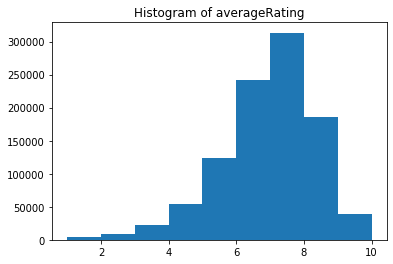

In [0]:
viz_histogram(df_ratings, 'averageRating', 9)

Our ratings range from **1** to **10**. The mean rating is **6.89** (maybe people are a little bit kinder than expected), with a standard deviation of roughly **1.40**. We have roughly **1 million** entries.

## How many votes does a movie have on average? (Box-Plot)

In [0]:
df_ratings.groupBy('tconst').mean('numVotes').describe().show()

+-------+---------+------------------+
summary| tconst| avg(numVotes)|
+-------+---------+------------------+
 count| 993821| 993821|
 mean| null| 955.4982275480193|
 stddev| null|15656.839581234844|
 min|tt0000001| 5.0|
 max|tt9916778| 2160364.0|
+-------+---------+------------------+

In [0]:
quantiles_votes = show_quantiles(df_ratings, 'numVotes', percentiles)

+---------+---------+
Pecentile| numVotes|
+---------+---------+
 0.1| 5.0|
 0.25| 8.0|
 0.5| 19.0|
 0.75| 74.0|
 0.9|2160364.0|
+---------+---------+

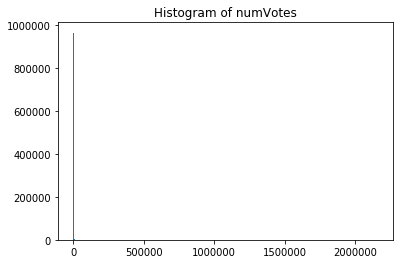

In [0]:
viz_histogram(df_ratings, 'numVotes', 1000)

# Feature Selection & Data Cleaning

In [0]:
df_final = '...'

# Write to S3

In [0]:
# TO DEFINE SHAPE OF TARGET DATASET

# id, rating, [list of features]

# sample of target dataset (e.g. 20%) write to s3

df_final.write('s3')

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3321533958678319> in <module> 
 5 # sample of target dataset (e.g. 20%) write to s3 
 6 
 ----> 7 df_final . write ( 's3' ) 

 NameError : name 'df_final' is not defined

In [0]:
print('cool')

cool